# Solving the Heat Equation with Quantum Computing
This notebook demonstrates how a simple 1D heat equation is solved using:
- Classical finite-difference time integration
- Normalization and mapping to a quantum problem
- Quantum Fourier transform (QFT)
- Variational Quantum Eigensolver (VQE)
- Final post-processing and de-normalization

in the **`Qiskit`** environment.

## Setup and imports

If running on [Google Colab](https://colab.research.google.com/), run the following cell before executing the rest of the code.

In [ ]:
%pip install qiskit
%pip install pylatexenc

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eigvalsh
from scipy.linalg import dft, inv
from scipy.optimize import minimize
import statistics
import time

from qiskit.circuit.library import efficient_su2
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram


# Preliminary steps

## Finite-Difference Scheme for Heat Conduction
We model the heat diffusion on a 1D spatial mesh with periodic boundary conditions using an implicit finite difference scheme:

- The temperature distribution at time $t=0$, $T_{old}$, is initialized using a sinusoidal perturbation.
- A matrix C is constructed based on the Fourier number r to represent the linear system.
- The new temperature distribution T_new is obtained by solving $C\cdot T_{new} = T_{old}$.

Visualization shows $T_{old}$ vs $T_{new}$.

In [2]:
n = 3  # number of qubits → number of spatial nodes = 2^n
N = 2**n

# Initial temperature profile (T_old)
T_old = 1 + 0.5 * np.sin(2 * np.pi * (np.arange(N) + 1) / N)

# Construct finite-difference matrix C
r = 0.5  # Fourier number
d = np.ones(N) * (1 + 2*r)
od = np.ones(N - 1) * (-r)
C = np.diag(d) + np.diag(od, -1) + np.diag(od, 1)
C[0, -1] = C[-1, 0] = -r  # periodic BC

# Solve implicit update T_new = C⁻¹ * T_old
T_new = inv(C) @ T_old

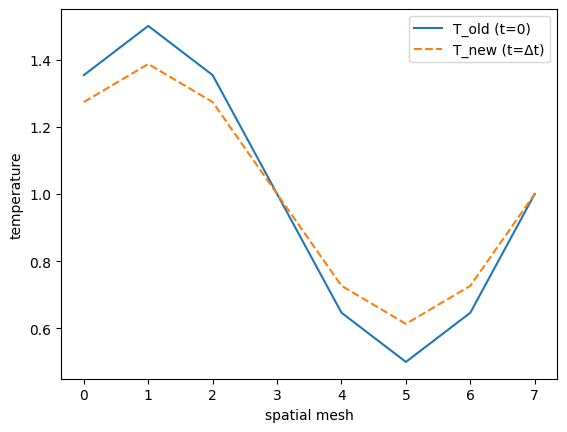

In [3]:
# Plotting the initial and updated temperature profiles
plt.plot(T_old, label='T_old (t=0)')
plt.plot(T_new, label='T_new (t=Δt)', linestyle='dashed')
plt.legend()
plt.xlabel('spatial mesh')
plt.ylabel('temperature')
plt.show()

## Normalization for Quantum Mapping
We normalize both $T_{old}$ and $T_{new}$ for compatibility with quantum state amplitudes (unit norm vectors):

1. Compute norms $b_0$ and $x_0$.
2. Define normalized vectors $b$ and $x_{th}$.
3. Construct normalized linear system $A \cdot x_{th} = b$, which will be used in quantum optimization.

In [4]:
# Normalize T_old
TT_old = np.sum(T_old**2)
b0 = np.linalg.norm(T_old)
b = T_old / b0

# Normalize T_new
TT_new = np.sum(T_new**2)
x0 = np.linalg.norm(T_new)
x_th = T_new / x0

# Normalize system matrix: A = f * C
f = x0 / b0
A = C * f

In [5]:
# Check consistency
assert np.allclose(b * b0, T_old)
assert np.allclose(x_th * x0, T_new)
assert np.allclose(C @ T_new, T_old)
assert np.allclose(A @ x_th, b)

In [6]:
# Check
print(b * b0 - T_old) # normalized linear system
print(x_th * x0 - T_new) # back to original units
print(C @ T_new - T_old) # original system
print(A @ x_th - b) # normalized system for quantum computing

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.11022302e-16]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  0.00000000e+00 -1.11022302e-16 -1.11022302e-16]
[-1.66533454e-16  1.11022302e-16 -5.55111512e-17  1.11022302e-16
 -5.55111512e-17 -2.77555756e-17 -8.32667268e-17 -5.55111512e-17]


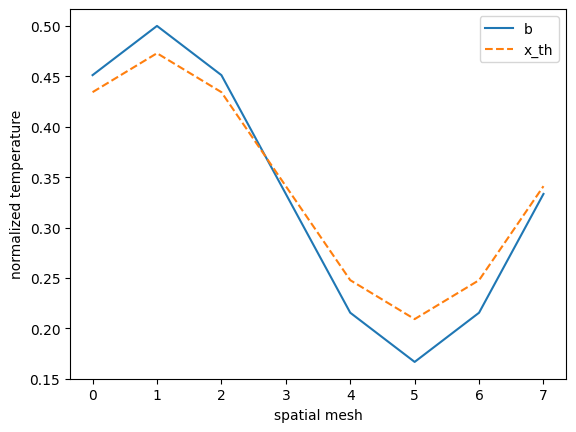

In [7]:
plt.plot(b, label='b')
plt.plot(x_th, label='x_th', linestyle='dashed')
plt.legend()
plt.xlabel('spatial mesh')
plt.ylabel('normalized temperature')
plt.show()

In [8]:
# PROOF for normalization
print( C @ T_new - T_old ) # original system
print( (C @ T_new)/(TT_new * TT_old) - T_old/(TT_new * TT_old) )
print( (C @ x_th)/(np.sqrt(TT_new) * TT_old) - b/(TT_new * np.sqrt(TT_old)) )
print( np.sqrt(TT_new/TT_old) * C @ x_th - b )
print( f * C @ x_th - b )
print( A @ x_th - b ) # normalized system for quantum computing

[-2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  0.00000000e+00 -1.11022302e-16 -1.11022302e-16]
[-3.46944695e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.46944695e-18  0.00000000e+00 -1.73472348e-18 -1.73472348e-18]
[-6.93889390e-18  0.00000000e+00 -6.93889390e-18  1.73472348e-18
 -5.20417043e-18 -1.73472348e-18 -3.46944695e-18 -3.46944695e-18]
[-1.66533454e-16  1.11022302e-16 -5.55111512e-17  1.11022302e-16
 -5.55111512e-17 -2.77555756e-17 -8.32667268e-17 -5.55111512e-17]
[-1.66533454e-16  1.11022302e-16 -5.55111512e-17  1.11022302e-16
 -5.55111512e-17 -2.77555756e-17 -8.32667268e-17 -5.55111512e-17]
[-1.66533454e-16  1.11022302e-16 -5.55111512e-17  1.11022302e-16
 -5.55111512e-17 -2.77555756e-17 -8.32667268e-17 -5.55111512e-17]


# Quantum Fourier Transform (QFT)
We implement QFT in two equivalent methods:

1. Using `numpy.fft.fft` with proper conjugation and scaling.
2. Explicit matrix multiplication with the discrete Fourier transform (`scipy.linalg.dft`).

This is useful for later transforming observables into the frequency domain.

In [9]:
# QFT via numpy
tildeb = np.conj(np.fft.fft(b) / np.sqrt(N))

# QFT via scipy and matrix multiplication
mydft = np.conj(dft(N) / np.sqrt(N))
tildeb_bis = mydft @ b
tildeb_bis[np.abs(tildeb_bis) < 1e-4] = 0

# Constructing the Quantum Observable
We define the observable operator for the VQE to minimize:

$O=A^\dagger\left(I-| b \rangle\langle b |\right)A$

This is the quantum observable for $T_{new}$, or better for $| x \rangle$ (normalized), such that:

$\langle x | \, O \, | x \rangle \xrightarrow{} 0$ (minimum) 

because $A^\dagger = f C^\dagger$, and then
$O=f^2 C^\dagger \left(I-| b \rangle\langle b |\right) C$
which has the same minimum for $| x \rangle$.

Ref: PHYSICAL REVIEW A 107, 052422 (2023)
Depth analysis of variational quantum algorithms for the heat equation

In [10]:
O = np.eye(N) - np.outer(b, b)
O = C.T @ O @ C  # O = C† (I - |b⟩⟨b|) C
observable_1 = SparsePauliOp.from_operator(O)

In [11]:
# Optional: check in Fourier space
FOF = mydft @ O @ mydft.conj().T
observable_2 = SparsePauliOp.from_operator(FOF)

DFOF = np.diag(np.diag(FOF))
observable_3 = SparsePauliOp.from_operator(DFOF)

In [12]:
# Eigenvalues of O give insight into the minimum
eigenvalues = eigvalsh(O)
print(eigenvalues)

[1.83512060e-15 1.59695367e+00 1.67157288e+00 4.00000000e+00
 4.00000000e+00 7.32842712e+00 7.32842712e+00 9.00000000e+00]


# Variational Quantum Eigensolver (VQE)
We use `Qiskit`'s estimator primitive to compute the expectation value of our observable under a parameterized ansatz.

## Loss/cost function for VQE
A custom cost function is defined for quantum optimization using `Qiskit`'s Estimator.
It returns the expectation value of the observable for a given ansatz and parameter set.

In [13]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

## Ansatz
We define the parameterized quantum circuit (ansatz) using `efficient_su2` for a good tradeoff between expressiveness and efficiency.

Optionally, a custom `TwoLocal` ansatz can be used.

The number of parameters and circuit structure are displayed.

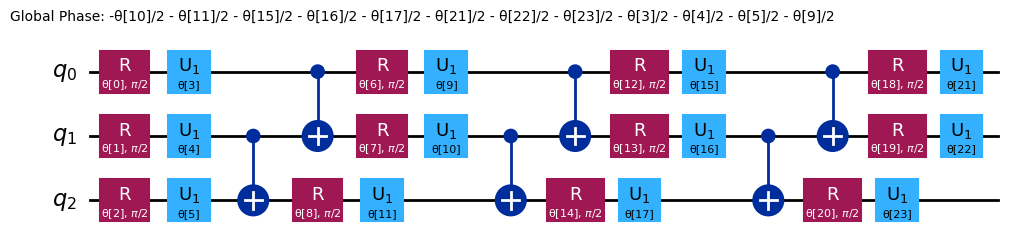

In [14]:
num_qubits = n
raw_ansatz = efficient_su2(num_qubits) # best HEURISTICS ansatz
raw_ansatz.decompose().draw('mpl')

An alternative ansatz is presented here:

In [15]:
# from qiskit import QuantumCircuit
#from qiskit.circuit.library import TwoLocal

# most RATIONAL ansatz
#reference_circuit = QuantumCircuit(num_qubits)
#reference_circuit.x(0)
#variational_form = TwoLocal(
#    num_qubits,
#    rotation_blocks=["ry"],
#    entanglement_blocks="cx",
#    entanglement="linear",
#    reps=2,
#)
#raw_ansatz = reference_circuit.compose(variational_form)

## Quantum Simulation Setup
We instantiate `StatevectorEstimator` and `StatevectorSampler` from Qiskit.

Initial parameter values $\theta_0$ are set to ones.

In [15]:
estimator = Estimator()
sampler = Sampler()

In [16]:
theta0 = np.ones(raw_ansatz.num_parameters)

## Quantum minimization / VQE optimization

We minimize the cost function using `SciPy`'s minimize with the `COBYLA` algorithm:

Optimizes ansatz parameters to minimize $\langle x | \, O \, | x \rangle$.

The result gives optimized parameters and circuit.

We visualize the output probability distribution and extract amplitudes as the quantum solution x.

See [here](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver) for more details.

Some experimental insights from Pietro:

Type of solver should be one of
- `Nelder-Mead`, nfev: 2461 (tol = 1e-2)
- `Powell`, nfev: 10027 (tol = 1e-2), disaster
- `CG`, nfev: 1600 (tol = 1e-2)
- `BFGS`, nfev: 650 (tol = 1e-2), not bad
- `L-BFGS-B`, nfev: 675 (tol = 1e-3), not bad (!)
- `TNC`, nfev: 2400 (tol = 1e-2)
- `COBYLA`, nfev: 839 (tol = 1e-3), nfev: 552 (tol = 1e-2), BEST BEST BEST (!)
- `COBYQA`, nfev: 592 (tol = 1e-2), not bad
- `SLSQP`, nfev: 662 (tol = 1e-3), not bad
- `trust-constr`, nfev: 850 (tol = 1e-2), not bad

- `Newton-CG`, Jacobian is required for Newton-CG method
- `dogleg`, Jacobian is required for dogleg minimization
- `trust-ncg`, Jacobian is required for Newton-CG trust-region minimization
- `trust-exact`, Jacobian is required for Newton-CG trust-region minimization
- `trust-krylov`, Jacobian is required for Newton-CG trust-region minimization

In [17]:
start_time = time.time()

result = minimize(
    cost_func_vqe,
    theta0,
    args=(raw_ansatz, observable_1, estimator),
    method="COBYLA",
    tol=1e-3,
    options={"maxiter": 1000000, "disp": True}
)
print(result)

execution_time = time.time() - start_time
print("Execution time (s):", execution_time)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 6.384518743602664e-06
       x: [ 1.413e+00  1.505e+00 ...  2.346e-01  6.184e-01]
    nfev: 842
   maxcv: 0.0
Execution time (s): 2.8929920196533203


## Quantum results

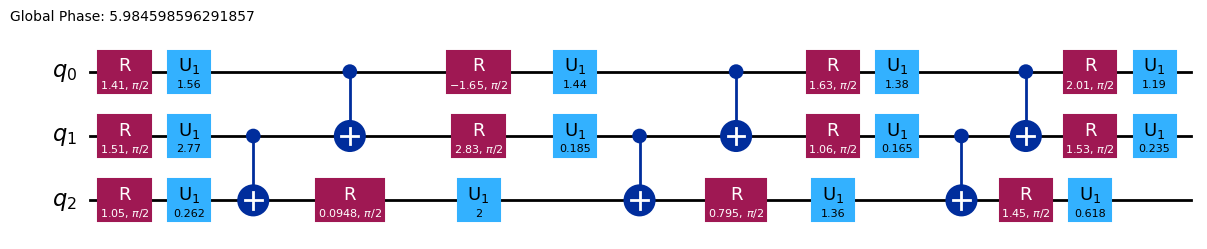

In [18]:
# Reconstruct the final state from optimized parameters
theta = result.x
ansatz = raw_ansatz.assign_parameters(theta)
ansatz.decompose().draw('mpl')

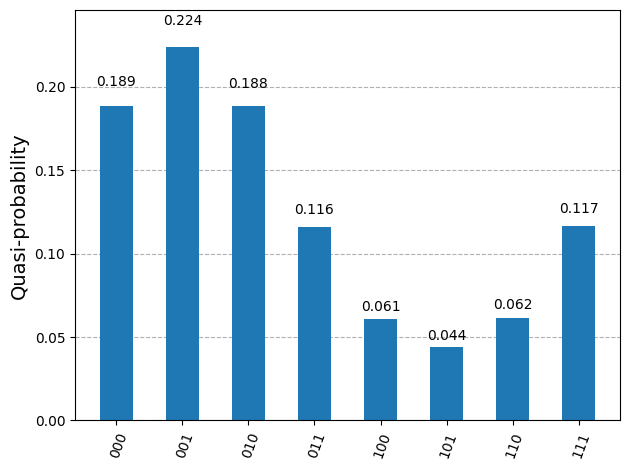

In [19]:
# Get ideal distribution
ideal_distribution = Statevector.from_instruction(ansatz).probabilities_dict()
plot_histogram(ideal_distribution)

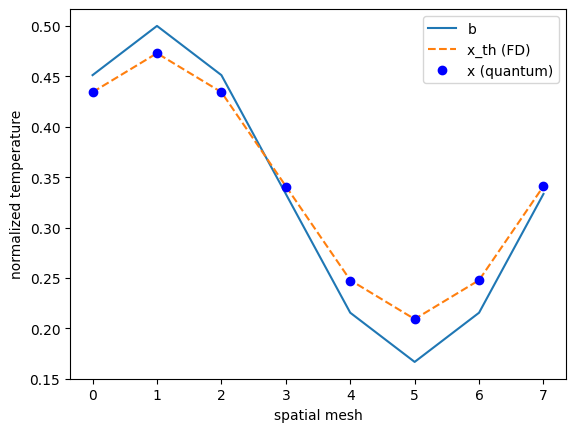

In [20]:
# Recover the amplitudes
y = np.real(list(ideal_distribution.values()))
x = np.sqrt(y)

plt.plot(b, label='b')
plt.plot(x_th, label='x_th (FD)', linestyle='dashed')
plt.plot(x, 'bo', label='x (quantum)')
plt.legend()
plt.xlabel('spatial mesh')
plt.ylabel('normalized temperature')
plt.show()

## Post-processing & De-normalization
Recover temperature in original units from normalized quantum solution using mean-scaling.

Compare classical $T_{new}$, quantum $T_{new,q}$, and original $T_{old}$.

In [21]:
x_mean = statistics.mean(x)
T_mean = statistics.mean(T_old)
scale = T_mean / x_mean
print(f"\nscale = {scale}")

T_new_q = x * scale


scale = 2.9321430020962214


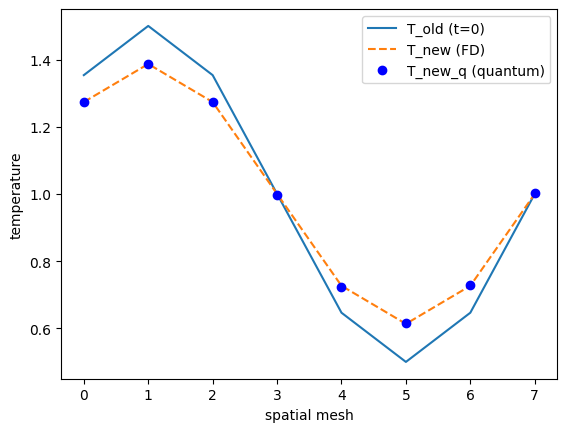

In [22]:
plt.plot(T_old, label='T_old (t=0)')
plt.plot(T_new, label='T_new (FD)', linestyle='dashed')
plt.plot(T_new_q, 'bo', label='T_new_q (quantum)')
plt.legend()
plt.xlabel('spatial mesh')
plt.ylabel('temperature')
plt.show()

# Summary
We’ve completed a full cycle:
1. Simulated the heat equation classically.
2. Reformulated it as a quantum optimization problem.
3. Used VQE with an ansatz to minimize a cost observable.
4. Compared the quantum and classical solutions.
5. Reconstructed physical units from quantum results.